In [ ]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'adverse-food-events:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F2383%2F4003%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240210%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240210T214332Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D9d0380caa2b8b8a4c803d4671dda104ec570e8671b24a5d738380e860a5bbef243413959d7cc5838b994248bd58fe5fc6ae0a526de025d5dc2396d7b41cb42b4d7395900a4a71c0a742b01333c6a183c7fb61b8df17bbb1f6976174350a0fccac9347159bbb82c116ca05f8752a2155dd905f49398827b2ce4c943c021bd3db11a60b97ddba31cedcbeb97affcb935c35915ecab95d365f406fdeeb8ea04f756f86a1a2ed488d5fc9a2a323e9b5155981754695226666b558fc0dda60b77ea6440d17de81bd9d0d7e00f3ae71b320d08e274961ab4c0bf4aafb7717ae3408b9a2985fdfb86b1e085ee3fae56d0d12a806852422bbedc09a413c36aba0e41d876'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/adverse-food-events/CAERS_ASCII_2004_2017Q2.csv
/kaggle/input/adverse-food-events/README.pdf


# IMPORTING DATA

In [ ]:
df = pd.read_csv('../input/adverse-food-events/CAERS_ASCII_2004_2017Q2.csv')

# Cleaning Data

In [ ]:
df.head()

,RA_Report #,RA_CAERS Created Date,AEC_Event Start Date,PRI_Product Role,PRI_Reported Brand/Product Name,PRI_FDA Industry Code,PRI_FDA Industry Name,CI_Age at Adverse Event,CI_Age Unit,CI_Gender,AEC_One Row Outcomes,SYM_One Row Coded Symptoms
0,65325,1/1/2004,8/4/2003,Suspect,MIDWEST COUNTRY FAIR CHOCOLATE FLAVORED CHIPS,3,Bakery Prod/Dough/Mix/Icing,2.0,Year(s),Female,"VISITED AN ER, VISITED A HEALTH CARE PROVIDER,...","SWELLING FACE, RASH, WHEEZING, COUGH, HOSPITAL..."
1,65325,1/1/2004,8/4/2003,Suspect,MIDWEST COUNTRY FAIR CHOCOLATE FLAVORED CHIPS,3,Bakery Prod/Dough/Mix/Icing,2.0,Year(s),Female,"VISITED AN ER, VISITED A HEALTH CARE PROVIDER,...","SWELLING FACE, WHEEZING, COUGH, RASH, HOSPITAL..."
2,65333,1/1/2004,NaN,Suspect,KROGER CLASSIC CREAM-DE-MINT CANDY MINT CHIP I...,13,Ice Cream Prod,NaN,Not Available,Female,VISITED AN ER,"NAUSEA, DYSGEUSIA, DIARRHOEA"
3,65335,1/1/2004,11/24/2003,Suspect,ENFAMIL LIPIL BABY FORMULA,40,Baby Food Prod,3.0,Month(s),Not Available,NON-SERIOUS INJURIES/ ILLNESS,"GASTROINTESTINAL DISORDER, VOMITING"
4,65336,1/1/2004,NaN,Suspect,ENFIMIL LIPIL BABY FORMULA,40,Baby Food Prod,NaN,Not Available,Not Available,VISITED A HEALTH CARE PROVIDER,"GASTROINTESTINAL DISORDER, PHYSICAL EXAMINATION"


In [ ]:
df.shape

(90786, 12)

In [ ]:
df.columns

Index(['RA_Report #', 'RA_CAERS Created Date', 'AEC_Event Start Date',
       'PRI_Product Role', 'PRI_Reported Brand/Product Name',
       'PRI_FDA Industry Code', 'PRI_FDA Industry Name',
       'CI_Age at Adverse Event', 'CI_Age Unit', 'CI_Gender',
       'AEC_One Row Outcomes', 'SYM_One Row Coded Symptoms'],
      dtype='object')

### Rename Columns

In [ ]:
df.rename(columns={"PRI_Reported Brand/Product Name":"products_name",
                   "SYM_One Row Coded Symptoms":"symptoms",
                   "CI_Gender":"gender",
                   "CI_Age at Adverse Event":"age",
                   "CI_Age Unit":"age_unit",
                   "RA_Report #":"no_report",
                   "RA_CAERS Created Date":"created_date",
                   "AEC_Event Start Date":"start_date",
                   "PRI_Product Role":"products_role",
                   "PRI_FDA Industry Code":"industry_code",
                   "AEC_One Row Outcomes":"Outcomes",
                   "PRI_FDA Industry Name":"products_types"},inplace=True)
df.columns

Index(['no_report', 'created_date', 'start_date', 'products_role',
       'products_name', 'industry_code', 'products_types', 'age', 'age_unit',
       'gender', 'Outcomes', 'symptoms'],
      dtype='object')

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90786 entries, 0 to 90785
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   no_report       90786 non-null  int64  
 1   created_date    90786 non-null  object 
 2   start_date      53653 non-null  object 
 3   products_role   90786 non-null  object 
 4   products_name   90786 non-null  object 
 5   industry_code   90786 non-null  int64  
 6   products_types  90786 non-null  object 
 7   age             52926 non-null  float64
 8   age_unit        90786 non-null  object 
 9   gender          90786 non-null  object 
 10  Outcomes        90786 non-null  object 
 11  symptoms        90781 non-null  object 
dtypes: float64(1), int64(2), object(9)
memory usage: 8.3+ MB


### Date Format

In [ ]:
df['created_date']=pd.to_datetime(df['created_date'], format='%m/%d/%Y')
df['start_date']=pd.to_datetime(df['start_date'], format='%m/%d/%Y')

In [ ]:
df.head(10)

,no_report,created_date,start_date,products_role,products_name,industry_code,products_types,age,age_unit,gender,Outcomes,symptoms
0,65325,2004-01-01,2003-08-04,Suspect,MIDWEST COUNTRY FAIR CHOCOLATE FLAVORED CHIPS,3,Bakery Prod/Dough/Mix/Icing,2.0,Year(s),Female,"VISITED AN ER, VISITED A HEALTH CARE PROVIDER,...","SWELLING FACE, RASH, WHEEZING, COUGH, HOSPITAL..."
1,65325,2004-01-01,2003-08-04,Suspect,MIDWEST COUNTRY FAIR CHOCOLATE FLAVORED CHIPS,3,Bakery Prod/Dough/Mix/Icing,2.0,Year(s),Female,"VISITED AN ER, VISITED A HEALTH CARE PROVIDER,...","SWELLING FACE, WHEEZING, COUGH, RASH, HOSPITAL..."
2,65333,2004-01-01,NaT,Suspect,KROGER CLASSIC CREAM-DE-MINT CANDY MINT CHIP I...,13,Ice Cream Prod,NaN,Not Available,Female,VISITED AN ER,"NAUSEA, DYSGEUSIA, DIARRHOEA"
3,65335,2004-01-01,2003-11-24,Suspect,ENFAMIL LIPIL BABY FORMULA,40,Baby Food Prod,3.0,Month(s),Not Available,NON-SERIOUS INJURIES/ ILLNESS,"GASTROINTESTINAL DISORDER, VOMITING"
4,65336,2004-01-01,NaT,Suspect,ENFIMIL LIPIL BABY FORMULA,40,Baby Food Prod,NaN,Not Available,Not Available,VISITED A HEALTH CARE PROVIDER,"GASTROINTESTINAL DISORDER, PHYSICAL EXAMINATION"
5,65345,2004-01-01,2003-12-21,Suspect,"FRITO LAY FUNYUNS ONION FLAVOR, ONION RINGS",7,Snack Food Item,10.0,Year(s),Male,NON-SERIOUS INJURIES/ ILLNESS,CHOKING
6,65350,2004-01-01,NaT,Suspect,GRAPE,20,Fruit/Fruit Prod,NaN,Not Available,Not Available,DEATH,"DEATH, CHOKING"
7,65353,2004-01-02,2003-12-01,Suspect,HERBALIFE RELAX NOW,54,Vit/Min/Prot/Unconv Diet(Human/Animal),NaN,Not Available,Female,VISITED A HEALTH CARE PROVIDER,"PARANOIA, PHYSICAL EXAMINATION, DELUSION"
8,65353,2004-01-02,2003-12-01,Suspect,HERBALIFE TOTAL CONTROL,54,Vit/Min/Prot/Unconv Diet(Human/Animal),NaN,Not Available,Female,VISITED A HEALTH CARE PROVIDER,"PARANOIA, PHYSICAL EXAMINATION, DELUSION"
9,65354,2004-01-02,NaT,Suspect,YOHIMBE,54,Vit/Min/Prot/Unconv Diet(Human/Animal),66.0,Year(s),Male,REQ. INTERVENTION TO PRVNT PERM. IMPRMNT.,BLOOD PRESSURE INCREASED


### Checking Null Data

Data is NULL:
 start_date    37133
age           37860
symptoms          5
dtype: int64


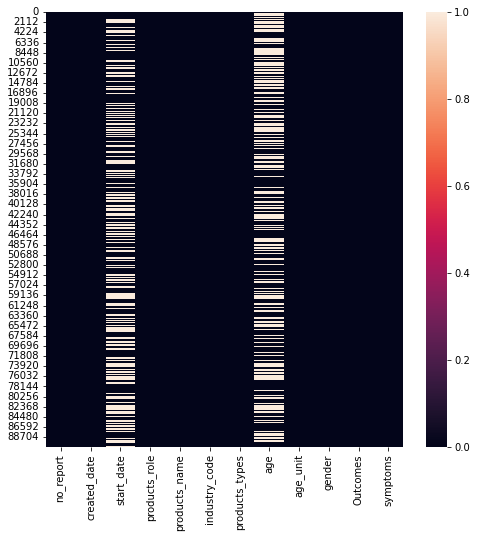

In [ ]:
print("Data is NULL:\n", df[df.columns[df.isnull().sum() != 0 ]].isnull().sum())

plt.figure(figsize=(8,8))
sns.heatmap(df.isnull())
plt.show()

### Duplicate Data

In [ ]:
print("Duplicate Data\n")
df.duplicated("no_report").value_counts()

Duplicate Data



False    64517
True     26269
dtype: int64

In [ ]:
df.drop_duplicates("no_report", keep="last", inplace=True)

print("Duplicate Data")
df.duplicated("no_report").value_counts()

Duplicate Data


False    64517
dtype: int64

# The Most Products Reported

## Product Type

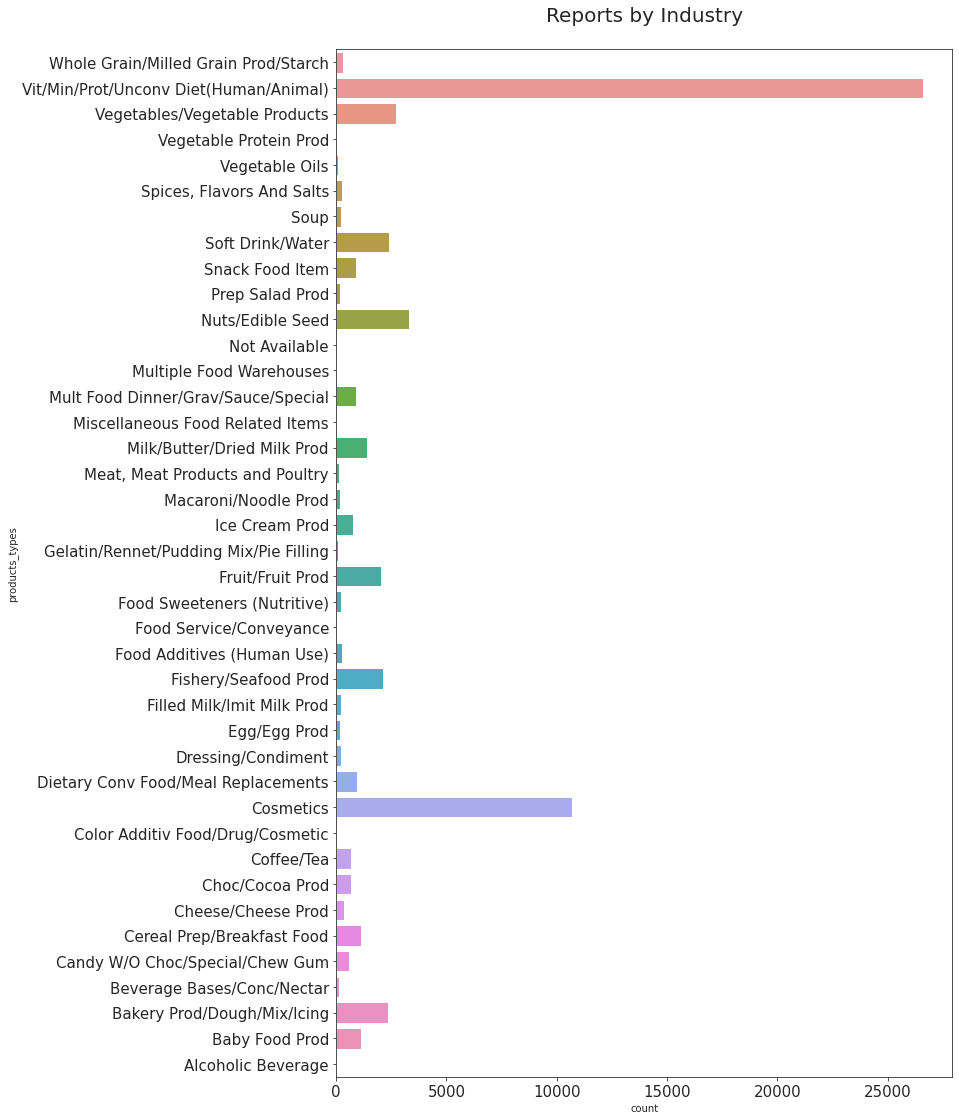

Vit/Min/Prot/Unconv Diet(Human/Animal)    26594
Cosmetics                                 10698
Nuts/Edible Seed                           3312
Vegetables/Vegetable Products              2707
Soft Drink/Water                           2380
Bakery Prod/Dough/Mix/Icing                2358
Fishery/Seafood Prod                       2116
Fruit/Fruit Prod                           2026
Milk/Butter/Dried Milk Prod                1385
Cereal Prep/Breakfast Food                 1134
Baby Food Prod                             1122
Dietary Conv Food/Meal Replacements         947
Snack Food Item                             929
Mult Food Dinner/Grav/Sauce/Special         904
Ice Cream Prod                              784
Choc/Cocoa Prod                             696
Coffee/Tea                                  683
Candy W/O Choc/Special/Chew Gum             582
Cheese/Cheese Prod                          341
Whole Grain/Milled Grain Prod/Starch        315
Food Additives (Human Use)              

In [ ]:
plt.figure(figsize=(12,15))
sns.set_style("ticks")
#df['products_types'].value_counts().sort_values(ascending=True).plot(kind='barh')
product= df["products_types"].sort_values(ascending=False)
sns.countplot(data=df, y=product)
plt.tight_layout()
plt.title('Reports by Industry\n',fontsize=20)
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)
plt.show()

df.products_types.value_counts().sort_values (ascending =False)

## Product Brand

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Glyph 146 (\x92) missing from current font.
  
/opt/conda/lib/python3.7/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 146 (\x92) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


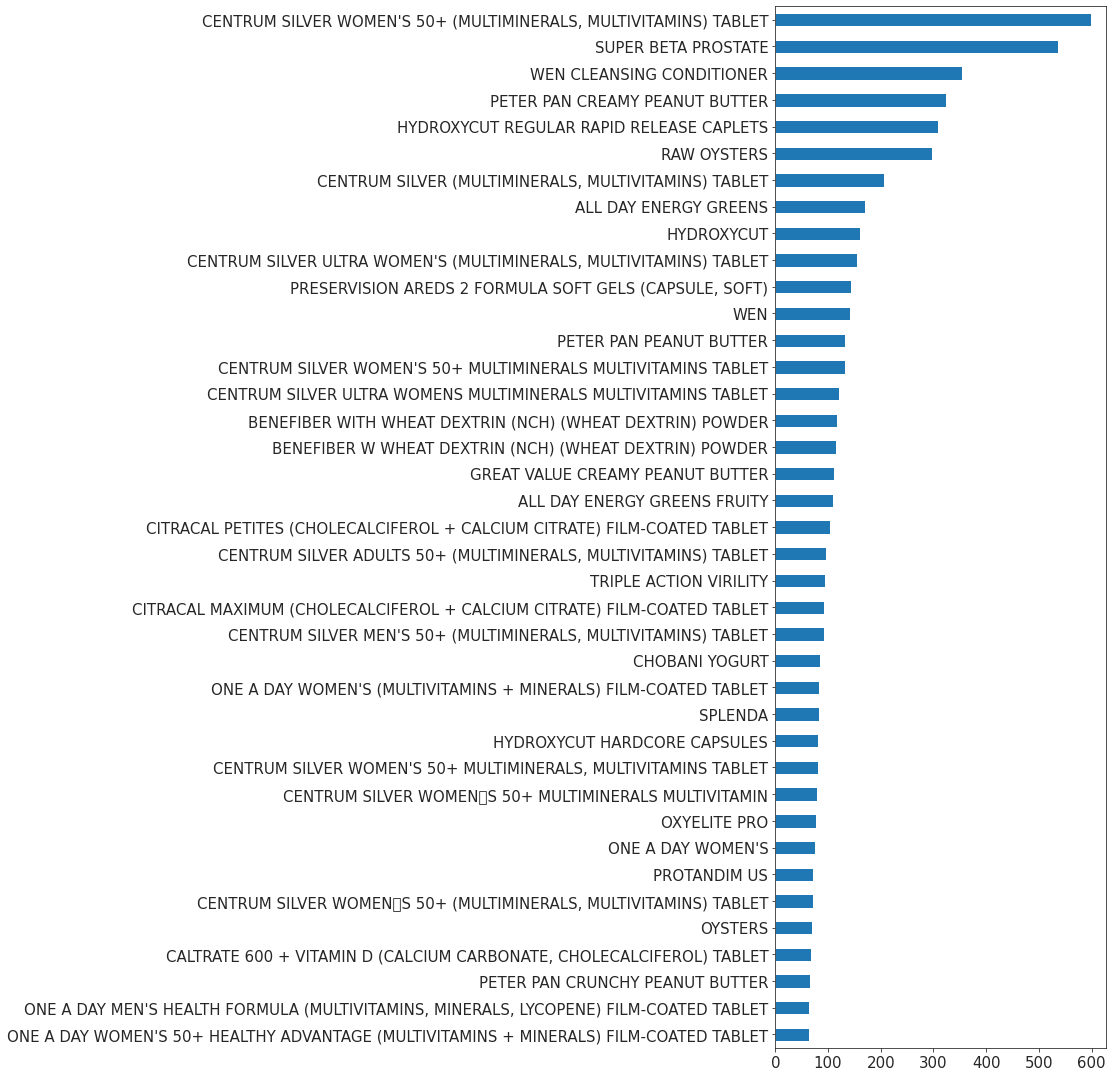

REDACTED                                                                                 6078
CENTRUM SILVER WOMEN'S 50+ (MULTIMINERALS, MULTIVITAMINS) TABLET                          598
SUPER BETA PROSTATE                                                                       536
WEN CLEANSING CONDITIONER                                                                 355
PETER PAN CREAMY PEANUT BUTTER                                                            324
HYDROXYCUT REGULAR RAPID RELEASE CAPLETS                                                  308
RAW OYSTERS                                                                               297
CENTRUM SILVER (MULTIMINERALS, MULTIVITAMINS) TABLET                                      206
ALL DAY ENERGY GREENS                                                                     171
HYDROXYCUT                                                                                160
CENTRUM SILVER ULTRA WOMEN'S (MULTIMINERALS, MULTIVITAMINS) 

In [ ]:
plt.figure(figsize=(12,15))
sns.set_style("ticks")
df["products_name"].value_counts()[1:40].sort_values(ascending = True).plot.barh()
#name= df["products_name"].sort_values(ascending=False)[1:40]
#sns.countplot(data=df, y=name)
plt.tight_layout()
plt.xticks(fontsize =15)
plt.yticks(fontsize =15)
plt.show()

df["products_name"].value_counts()[0:41].sort_values (ascending =False)

# The Most Symptoms

Text(0.5, 1.0, 'Health event counts by product type')

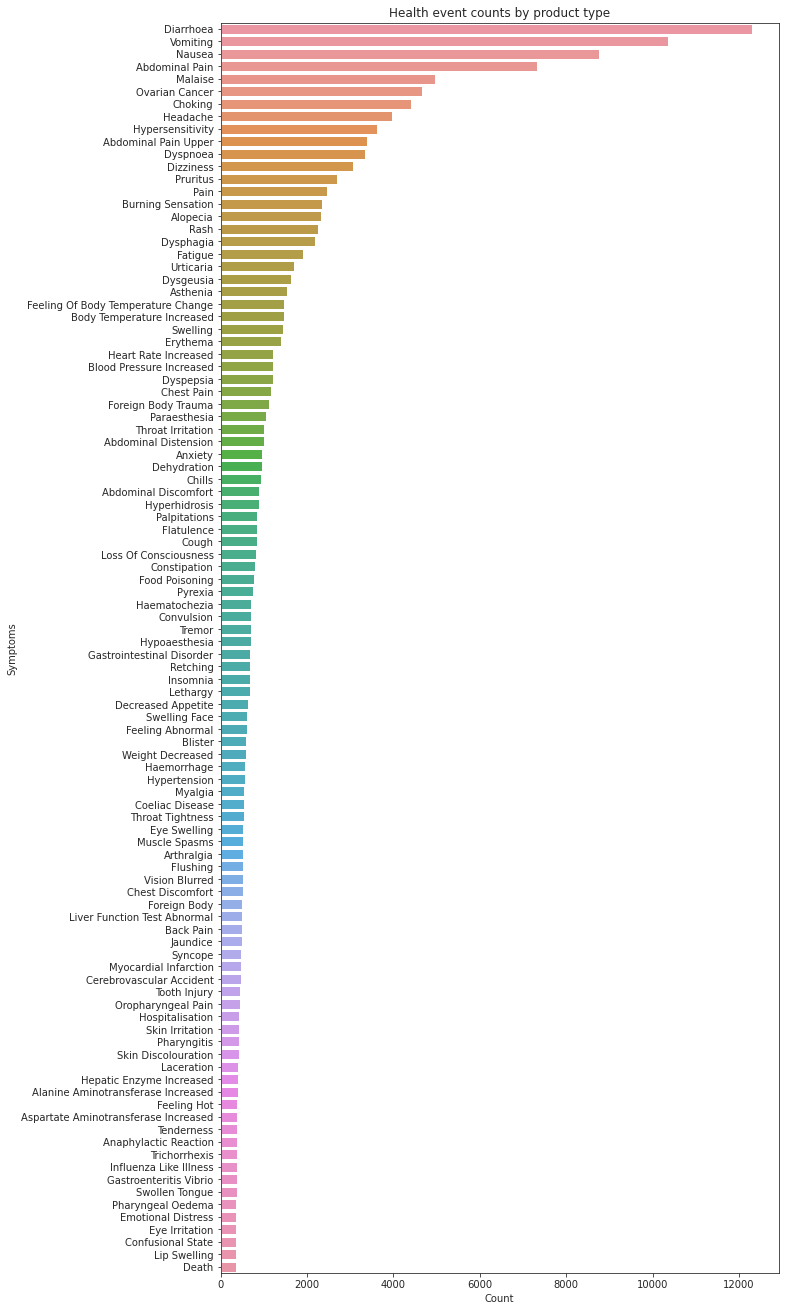

In [ ]:
symptoms=[]
for _, reactions in df['symptoms'].astype(object).str.split(",").iteritems():
    symptoms += [str(l).strip().title() for l in pd.Series(reactions).astype(object)]

outcome_df=pd.DataFrame({'Symptoms':pd.Series(symptoms).value_counts().index, 'Count':pd.Series(symptoms).value_counts()})[:100]
fig, ax = plt.subplots(figsize=(10,23))
sns.barplot(x='Count',y='Symptoms', data=outcome_df).set_title('Health event counts by product type')

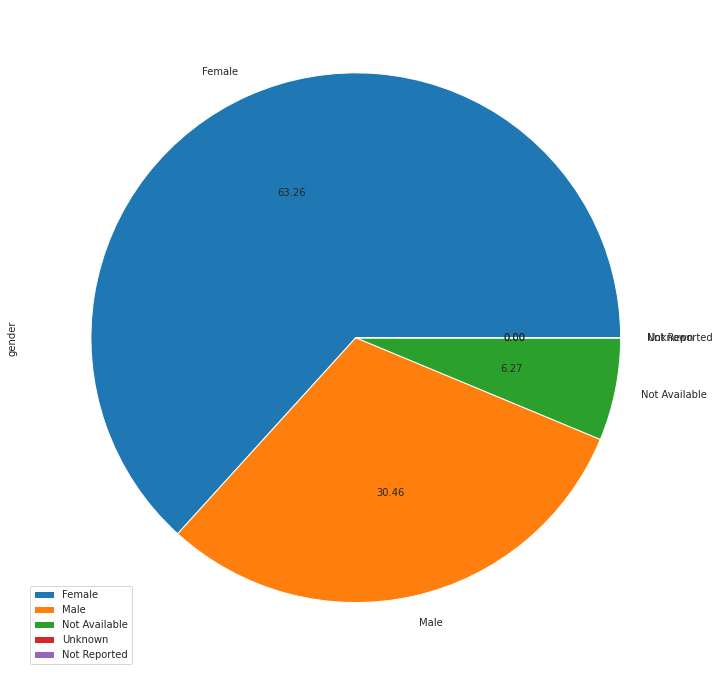

In [ ]:
plt.figure(figsize=(10,10))
df['gender'].value_counts().plot.pie(autopct='%.2f', legend=True)
plt.tight_layout()

# Outcomes

Text(0.5, 1.0, 'What The Output?')

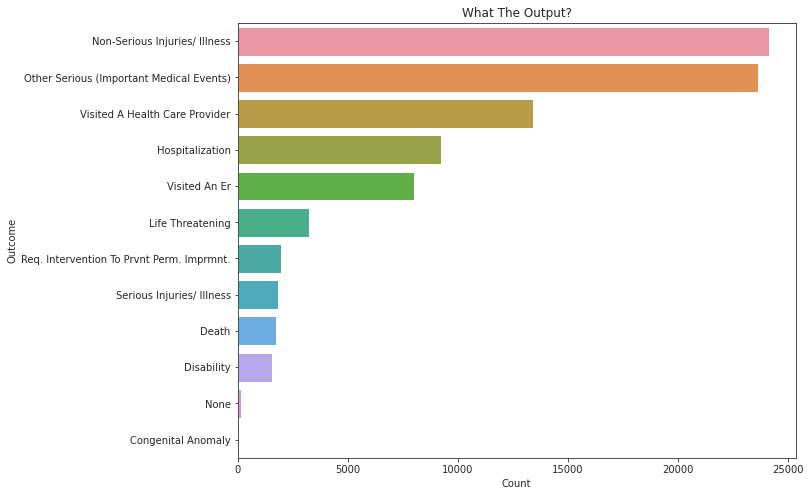

In [ ]:

outcomes=[]
for _, reactions in df['Outcomes'].astype(object).str.split(",").iteritems():
    outcomes += [str(l).strip().title() for l in pd.Series(reactions).astype(object)]

outcome_df=pd.DataFrame({'Outcome':pd.Series(outcomes).value_counts().index, 'Count':pd.Series(outcomes).value_counts()})[:100]
fig, ax = plt.subplots(figsize=(10,8))
sns.barplot(x='Count',y='Outcome', data=outcome_df).set_title('What The Output?')
#plt.figure(figsize=(12,8))
#df['Outcomes'].value_counts()[0:40].sort_values(ascending = True).plot.barh()
#plt.title('Outcome of People')
#plt.xlabel('Count')
#plt.tight_layout()
#plt.show()

# Deadly


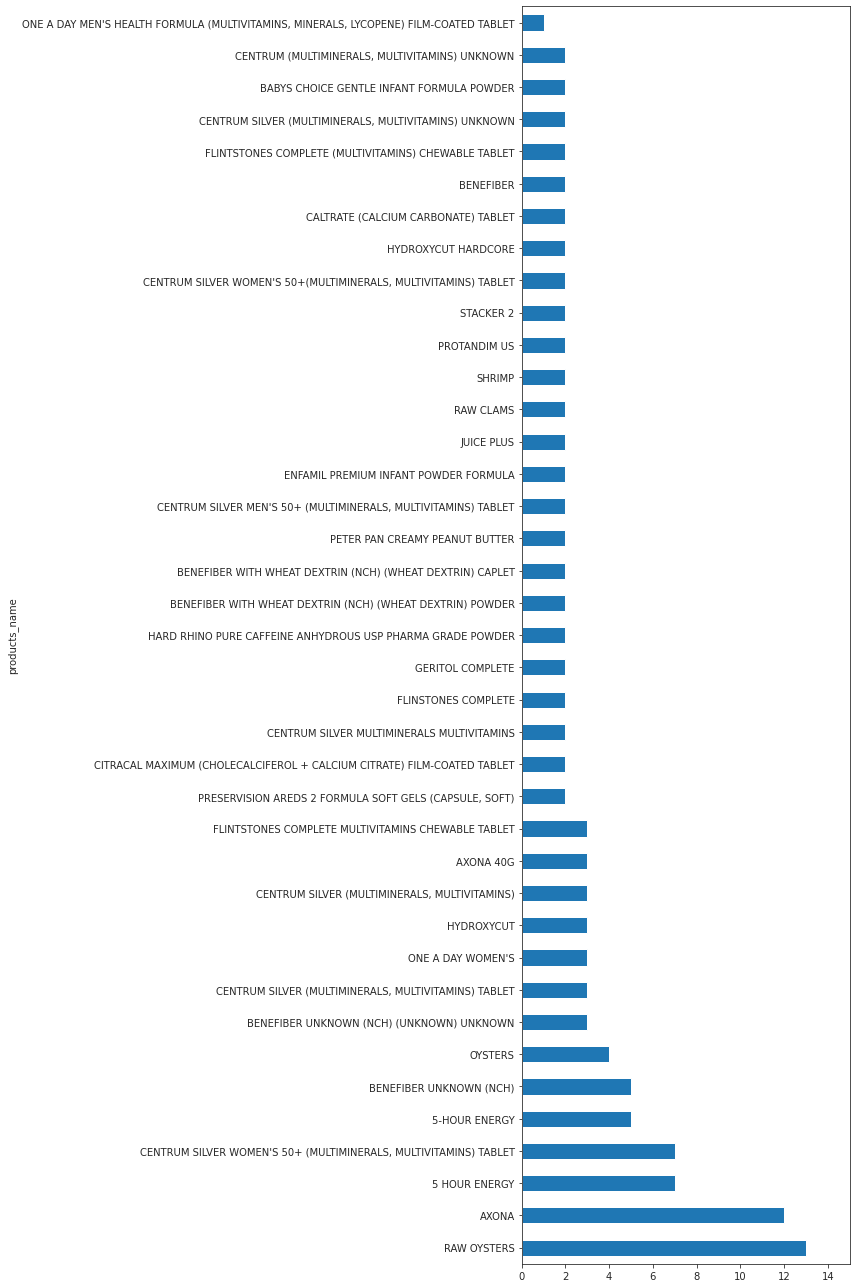

In [ ]:
mati=df[(df['symptoms']!=np.NaN) & (df['symptoms'].str.contains('DEATH'))]
produk=mati.groupby('products_name').size()
plt.figure(figsize = (12,18))
produk.sort_values(ascending=False)[1:40].plot.barh()
plt.xlim(0,15)
plt.tight_layout()